<a href="https://colab.research.google.com/github/liuy01510/portfolio/blob/master/Optimization_I_Separable_Programming_PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
- The objective of this script is to learn the methods of separable programming to model and solve non-linear & separable problems.


# Installing the required modules
- Google OR-Tools library will be used to provide the LP modeller and solver.

In [0]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# Installing the library if its not present
try:
    import ortools
except:
    !pip install ortools

# Given Example
Maximize the following equation:

$f(x)=20x_1+16x_2-2x_1^2-x_2^2-(x_1+x_2)^2$

Constraints:

$x_1+x_2 \leq 5$

$x_1,x_2 \geq 0$

- On initial inspection, the problem seems to be unseparable, due to the presence of the term $(x_1+x_2)^2$.
- However, if the substitution of $x_3=x_1+x_2$ can be made, the objective function then becomes separable.
- $\therefore$ after making the substitution, the objective function can be rewritten as:

$f(x)=20x_1+16x_2-2x_1^2-x_2^2-x_3^2$

- Additional constraints:

$x_3>0$

$x_1+x_2-x_3=0$

- The new objective function is now separable:

$f_1(x)=20x_1-2x_1^2$

$f_2(x)=16x_2-x_2^2$

$f_3(x)=-x_3^2$

$f(x)=f_1(x)+f_2(x)+f_3(x)$

- The bounds of the variables are:

$x_1 = x_2 = x_3 = (0,5)$

# Plotting the separate objective functions

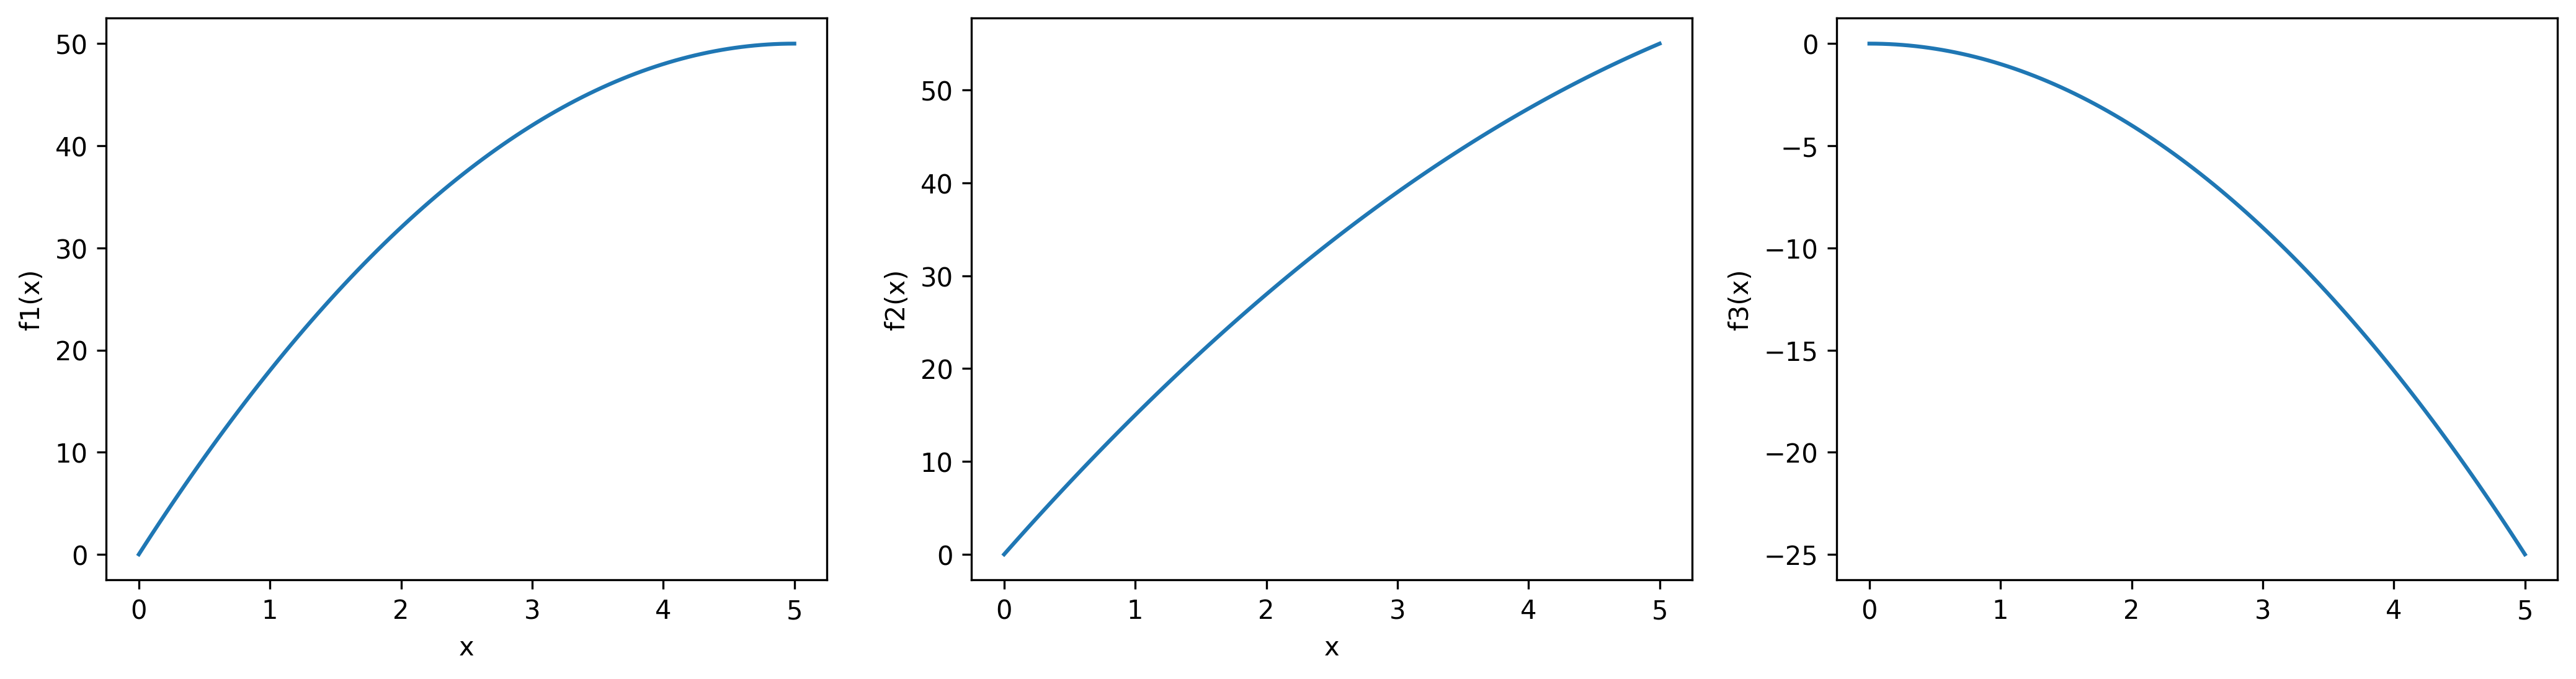

In [104]:
# Creating the plots
fig=plt.Figure(figsize=(17,4),dpi=300)
ax1=fig.add_subplot(131) # 1 row, 3 cols, 1st position.
ax2=fig.add_subplot(132) # 1 row, 3 cols, 1st position.
ax3=fig.add_subplot(133) # 1 row, 3 cols, 1st position.


# Defining the seperated functions
def fx1(x):
    return (20*x)-(2*(x**2))

def fx2(x):
    return (16*x)-(x**2)

def fx3(x):
    return -1*(x**2)

# Plotting the separable functions
x=np.linspace(0,5,100)
y1=[fx1(i) for i in x]
y2=[fx2(i) for i in x]
y3=[fx3(i) for i in x]

ax1.plot(x,y1,'-',label='fx1')
ax1.set_ylabel('f1(x)')
ax1.set_xlabel('x')
ax2.plot(x,y2,'-',label='fx2')
ax2.set_ylabel('f2(x)')
ax2.set_xlabel('x')
ax3.plot(x,y3,'-',label='fx3')
ax3.set_ylabel('f3(x)')
ax2.set_xlabel('x')
fig

# Plotting the approximation curves
- The approximation curves are plotted by the points ($\lambda$) used to approximate the original separable functions.
- For all three functions, the following x points will be used:
    - x = 1
    - x = 3
    - x = 5

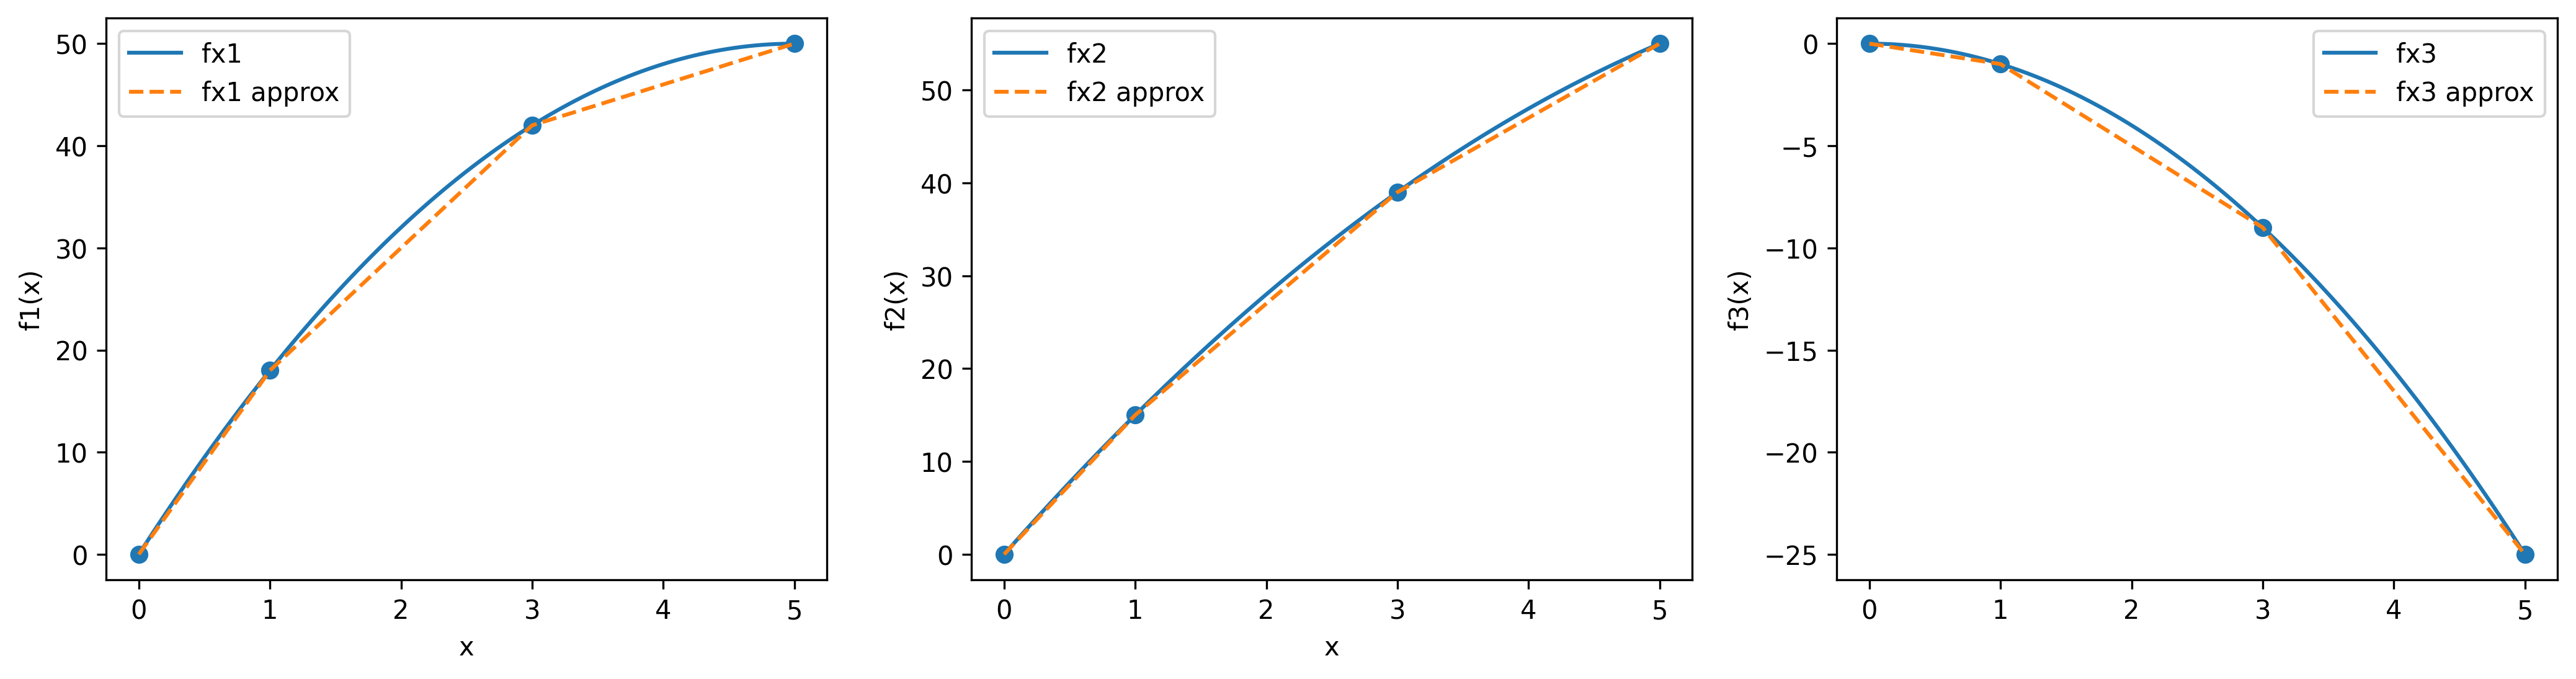

In [105]:
xa=[0,1,3,5]
ya1=[fx1(i) for i in xa]
ya2=[fx2(i) for i in xa]
ya3=[fx3(i) for i in xa]

ax1.scatter(xa,ya1)
ax1.plot(xa,ya1,'--',label='fx1 approx')
ax2.scatter(xa,ya2)
ax2.plot(xa,ya2,'--',label='fx2 approx')
ax3.scatter(xa,ya3)
ax3.plot(xa,ya3,'--',label='fx3 approx')

ax1.legend()
ax2.legend()
ax3.legend()
fig

- Due to the concavity of all the separable objective functions, the maximization of each of their functions will always lead to the adjacency conditions being met.
- Based on the approximation, $\lambda$ weights will be used to assign which of the weights will be active during the optimization process.
    - $\lambda=$ weight at each $x_{\text{approx}}$ point.
- For instance, for $x_1$:
    - $x_1=[0,1,3,5]=0\lambda_{01}+1\lambda_{11}+3\lambda_{21}+5\lambda_{31}$
    - $f(x_1)=[0,18,42,50]=0\lambda_{01}+18\lambda_{11}+42\lambda_{21}+50\lambda_{31}$

- $\lambda$ will have two conditionals:
    - $\sum_{i=1}^n \lambda =1$
    - $\lambda_i+\lambda_{i+1}=1$ (Adjacency conditional)

# Formulating the revised LP formula
- Rewrite the LP case in terms of $\lambda$.

In [106]:
# Creating the LP model parameters
from ortools.linear_solver import pywraplp

solver=pywraplp.Solver('Sep Prog',pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
# Initializing the LP variables
v={} # holds all the LP vars
for i in range(len(ya1)):
    v[f'l_{i}{1}']=solver.NumVar(0,np.inf,f'l_{i}{1}')
for i in range(len(ya2)):
    v[f'l_{i}{2}']=solver.NumVar(0,np.inf,f'l_{i}{2}')
for i in range(len(ya3)):
    v[f'l_{i}{3}']=solver.NumVar(0,np.inf,f'l_{i}{3}')


# Defining the constraints
c={} # LP constraint dict

## x1+x2<=5 constraint
c[0]=solver.Constraint(0,5)
for i,x in enumerate(xa): # for x1
    c[0].SetCoefficient(v[f'l_{i}{1}'],x)
for i,x in enumerate(xa): # for x2
    c[0].SetCoefficient(v[f'l_{i}{2}'],x)

## x1+x2-x3=0 constraint
c[1]=solver.Constraint(0,0)
for i,x in enumerate(xa):
    c[1].SetCoefficient(v[f'l_{i}{1}'],x)
for i,x in enumerate(xa):
    c[1].SetCoefficient(v[f'l_{i}{2}'],x)
for i,x in enumerate(xa):
    c[1].SetCoefficient(v[f'l_{i}{3}'],-1*x)

## sum(x)==1 constraint
for i in [1,2,3]:
    cons=solver.Constraint(1,1)
    for j in range(len(xa)):
        cons.SetCoefficient(v[f'l_{j}{i}'],1)
    
# Setting the objective function
obj=solver.Objective()
for i,y in enumerate(ya1):
    obj.SetCoefficient(v[f'l_{i}{1}'],y)
for i,y in enumerate(ya2):
    obj.SetCoefficient(v[f'l_{i}{2}'],y)
for i,y in enumerate(ya3):
    obj.SetCoefficient(v[f'l_{i}{3}'],y)
obj.SetMaximization()

status=solver.Solve()

if status==solver.OPTIMAL:
    for j in [1,2,3]:
        for i in [0,1,2,3]:
            if v[f'l_{i}{j}'].solution_value()>0:
                print(f"l_{i}{j}={v[f'l_{i}{j}'].solution_value()}")

l_11=0.4999999999999993
l_21=0.5000000000000007
l_22=0.9999999999999998
l_33=1.0


- The following values are provided by the optimal solution of the LP solver:
    - $\lambda_{11}=0.5$
    - $\lambda_{21}=0.5$
    - $\lambda_{22}=1$
    - $\lambda_{33}=1$
- Subtituting these lambda values into their respective separable functions:
    - $x_1=0(0)+0.5(1)+0.5(3)+0(5)=2$
        - $f(x_1)=20(2)-2(2^2)=32$
    - $x_2=0(0)+0(1)+1(3)+0(5)=3$
        - $f(x_2)=16x_2-x_2^2=39$
    - $x_3=0(0)+0(1)+0(3)+1(5)=5$
        - $f(x_3)=-x_3^2=-25$
- $\therefore$ The objective function optimal result can be computed:
    - $f(x)=f(x_1)+f(x_2)+f(x_3)=32+39-25=46$
    - The actual optimal for this objective function is $46 \frac{1}{3}$, and thus the LP optimal result is quite close to the actual optimal.
